# Conditional Score-based Diffusion Models for Time Series Imputation

Time series data, especially in healthcare and finance, often contain gaps resulting from sensor failures or incomplete data capture. Traditional imputation methods typically overlook the complex temporal dependencies inherent in time series data. CSDI addresses these challenges by using a conditional diffusion process to impute missing values, leveraging observed data to guide the imputation process.

This notebook investigates the application of Conditional Score-based Diffusion Models (CSDI) to time series imputation. Developed by researchers at Stanford University, CSDI adapts diffusion model principles, primarily used in image and audio synthesis, to effectively handle missing data in time series. These models have shown remarkable success in various generative tasks, such as image and audio synthesis, and are now adapted for time series imputation. In this notebook, we will implement the CSDI model using PyTorch and evaluate its performance on real-world datasets for time series imputation. The notebook is organized as follows:

1. [Library Imports and Model Setup]()


2. [Configuration and Argument Parsing]()


3. [Physio Dataset]()

	3.1. [Download Dataset]()
    
	3.2. [Data Loaders]()

	3.3. [Visualizing Time Series Data]()
    

4. [CSDI Algorithem]()

	4.1. [Experiment Setup and Execution]()

	4.2. [Model Training]()

	4.3. [Loading Pretrained Model]()

	4.4. [Model Evaluation]()


5. [Results Visualziation]()

# Library Imports and Model Setup

We first start with importing necessary libraries and modules required for the implementation of the CSDI model. This includes standard data handling libraries like `numpy` and `pandas`, deep learning libraries from `torch`, and specific components for building and training the CSDI model.

In [29]:
import os
import sys
import torch
import torch.nn as nn
import yaml
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import wget
import datetime
import seaborn as sns
import pickle
import pandas as pd
from pprint import pprint

# Add the parent directory to sys.path to import local modules
sys.path.append(os.path.abspath(os.path.join("..")))

from main_model import CSDI_Physio
from dataset.dataset_physio import get_dataloader
from dataset.dataset_download import download_physio_data
from util.utils import train, evaluate
from diff_models import diff_CSDI
from main_model import CSDI_base

# Configuration and Argument Parsing
The experiment's settings are loaded from a YAML configuration file, allowing easy adjustments to the model and training parameters. Modifications to these settings via command line arguments are directly reflected in the configuration, ensuring that each experiment can be finely tuned. Here bellow we explain the parameters defined in the configuration file:

- `epochs`: Number of complete passes through the training dataset.
- `batch_size`': Number of training examples used to estimate the gradient during training.
- `lr`: Learning rate, controls how much to change the model in response to the estimated error each time the model weights are updated.
- `itr_per_epoch`: Number of iterations per epoch; 
- `layers`: Number of layers in the diffusion model.
- `channels`: Number of channels in each layer, relates to the complexity and capacity of the model.
- `nheads`: Number of attention heads in each layer, for models using multi-head attention.
- `diffusion_embedding_dim`:Dimensionality of the embedding space for the diffusion process.
- `beta_start`: Starting value of the variance schedule in the diffusion process.
- `beta_end`: Ending value of the variance schedule, controls how noise evolves over diffusion steps.
- `num_steps`: Number of steps in the diffusion process, from start to end.
- `schedule`: Type of scheduling for the noise levels; 'quad' likely refers to quadratic scheduling.
- `is_linear`: Indicates the progression of the noise schedule is not linear.

In [30]:
def load_config(config_path="config/base.yaml"):
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config


config = load_config()
pprint(config)

{'diffusion': {'beta_end': 0.5,
               'beta_start': 0.0001,
               'channels': 64,
               'diffusion_embedding_dim': 128,
               'is_linear': False,
               'layers': 4,
               'nheads': 8,
               'num_steps': 50,
               'schedule': 'quad'},
 'model': {'featureemb': 16,
           'is_unconditional': 0,
           'target_strategy': 'random',
           'test_missing_ratio': 0.1,
           'timeemb': 128},
 'train': {'batch_size': 16,
           'epochs': 200,
           'itr_per_epoch': 100000000.0,
           'lr': 0.001}}


### Device Configuration
We also determine the appropriate computation environment. If a GPU is available, the model will utilize it for faster computation; otherwise, it defaults to using the CPU. This ensures that the setup is optimized for performance regardless of the hardware available.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Physio Dataset

This dataset is sourced from the PhysioNet Computing in Cardiology Challenge 2012. It includes clinical data aimed at predicting ICU patient mortality, based on information from the first 48 hours of ICU admission. Data comprises anonymized records from adult ICU admissions, focusing on early measurements that are critical for outcome predictions.

## Features
**Demographic Information**
- Age, Gender, Weight

**Vital Signs** (Time-series)
- Heart rate, Blood pressure, Respiratory rate, Temperature

**Laboratory Tests** (Time-series)
- Blood gases, Complete blood counts, Metabolic panels

**Outcomes**
- Length of stay in ICU,  Survival status at hospital discharge



## Download Dataset

We first start with downloading the PhysioNet dataset using `download_physio_data` function, which contains time series data for various physiological signals. 

In [32]:
# Path to the dataset directory and the tar file
data_dir = "data/"
dataset_tar_path = "data/set-a.tar.gz"
extracted_dir_path = "data/physio"
# Call the data function to check, download, and extract the dataset
download_physio_data(data_dir,dataset_tar_path, extracted_dir_path)

Dataset tar file already downloaded.
Dataset already extracted.


## Data Loaders
Data loaders are set up for the training, validation, and testing phases. These loaders are crucial for managing the data flow during model training and evaluation, ensuring efficient handling of data batches and the appropriate application of missing data simulations as specified in the experimental setup.


In [33]:
# Set up dataloaders
train_loader, valid_loader, _ = get_dataloader(
    seed=1,
    nfold=0, #fold of the data used for testing in a k-fold cross-validation setting
    batch_size=config["train"]["batch_size"],
    missing_ratio=config["model"].get("test_missing_ratio", 0.1),
)

## Visualizing Time Series Data

This section outlines how to effectively visualize time series data to study various physiological attributes using specific functions designed to highlight different aspects of the data. These visualizations aid in exploratory data analysis, offering insights into trends, distributions, and potential relationships within the dataset. 

### Attribute List

To start visualizing the data, we first load the dataset and make a list of the attributes available in the dataset. This information is crucial for selecting the attributes to visualize and analyze.

The dataset includes a range of physiological attributes critical for medical analysis and predictive modeling in healthcare contexts, such as heart rate (HR), blood pressure measurements (DiasABP, SysABP), and biochemical markers (Lactate, Glucose).

In [34]:
attributes = [
    "DiasABP",
    "HR",
    "Na",
    "Lactate",
    "NIDiasABP",
    "PaO2",
    "WBC",
    "pH",
    "Albumin",
    "ALT",
    "Glucose",
    "SaO2",
    "Temp",
    "AST",
    "Bilirubin",
    "HCO3",
    "BUN",
    "RespRate",
    "Mg",
    "HCT",
    "SysABP",
    "FiO2",
    "K",
    "GCS",
    "Cholesterol",
    "NISysABP",
    "TroponinT",
    "MAP",
    "TroponinI",
    "PaCO2",
    "Platelets",
    "Urine",
    "NIMAP",
    "Creatinine",
    "ALP",
]


### Time Series Plot

This plot helps in identifying patterns, trends, and cyclic behavior over time. First we implement a function to plot the time series data for a specific attribute:

In [35]:
def plot_time_series(loader, attribute_index):
    all_times = []
    all_values = []

    # Loop through each batch in the loader
    for batch in loader:
        # Get the observed data and time points
        observed_data = batch['observed_data']
        timepoints = batch['timepoints']
        
        # Extract values for the specific attribute
        values = observed_data[:, :, attribute_index]
        
        # Append data
        all_times.append(timepoints.numpy())  # Convert to numpy array if needed
        all_values.append(values.numpy())  # Convert to numpy array if needed

    # Concatenate all collected data
    times = np.concatenate(all_times)
    values = np.concatenate(all_values)
    
    # Plot the time series
    plt.figure(figsize=(15, 5))
    plt.plot(times, values, label=f'Time Series of {attributes[attribute_index]}', color='blue')
    plt.title(f'Time Series Plot of {attributes[attribute_index]}')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

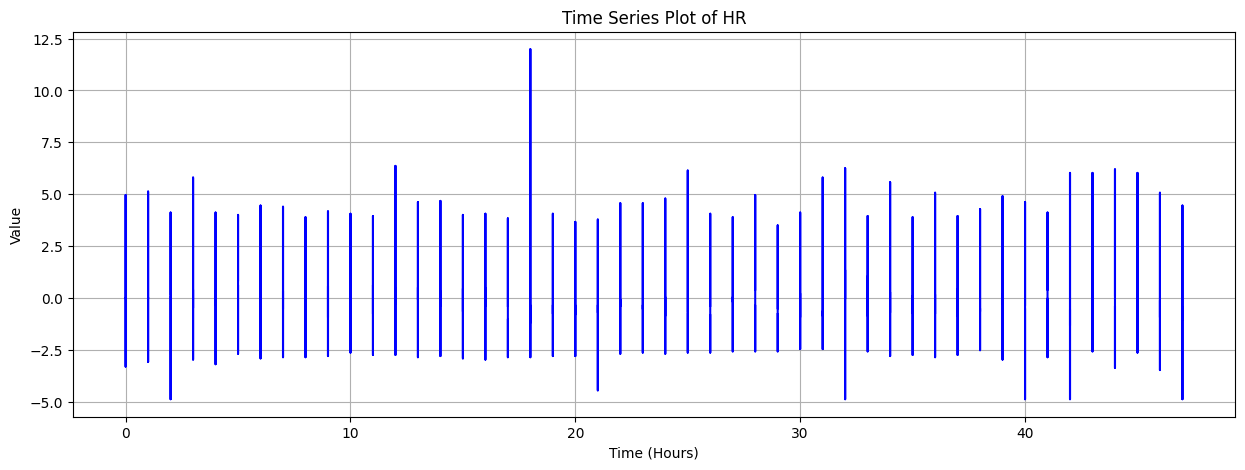

In [36]:
plot_time_series(train_loader, 1)

Here we plot the first attribute to show the general structure of the time series data. You can investigate other attributes by changing the index in the `plot_time_series` function.

#### Overview of the Plot
- **X-axis (Time in Hours)**: Represents the time from 0 to 48 hours, showing the progression of hours in a two-day period.
- **Y-axis (Value)**: Displays the HR values. The scale ranges from approximately -5 to 12.5, indicating the observed heart rate values over time.

#### Analysis of the Plot
- **Variability**: The plot shows significant variability in HR values throughout the 48-hour period. The HR values fluctuate frequently, suggesting periods of varying cardiac activity or measurement artifacts.
- **Outliers**: There are several spikes where the HR values rise sharply above the general level or drop below it. These could represent moments of stress, physical activity, or possibly errors in data collection or anomalies in measurement.
- **General Observations**: Most HR values seem to fluctuate around a central band between 0 and 5, with frequent deviations above and below this range.



### Histogram Plot
This plot is useful for checking the normality of the data and spotting any biases in the data collection process. Similar to the time series plot, but focuses on the distribution rather than the temporal changes.

In [37]:
def plot_histogram(loader, attribute_index):
    all_values = []

    for batch in loader:
        all_values.append(batch["observed_data"][:, :, attribute_index])

    values = np.concatenate(all_values, axis=0).flatten()

    plt.figure(figsize=(10, 5))
    plt.hist(values, bins=50, color="gray")
    plt.title(f"Histogram of {attributes[attribute_index]}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

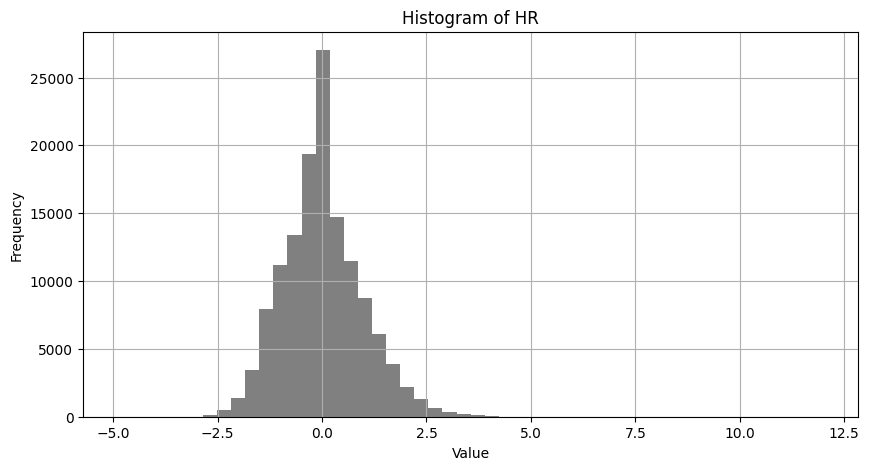

In [38]:

plot_histogram(train_loader, 1)  # Adjust the attribute index as needed

Here we againplot the first attribute. You can investigate other attributes by changing the index in the `plot_histogram` function.

#### Overview & Interpretation of the Histogram
- **X-axis (Value)**: Represents the HR (Heart Rate) values.
- **Y-axis (Frequency)**: Indicates the number of occurrences for each HR value range, illustrating how frequently each range appears in the dataset.
- **Central Peak**: The highest peak around the zero value suggests that the most common HR values are centered around this point.
- **Symmetry and Shape**: The histogram appears roughly symmetric about the central peak, implying a normal distribution of HR values. This symmetry suggests that values of HR equally deviate around a central value with no significant skewness toward high or low extremes.
- **Spread**: The spread from approximately -5 to 5 covers the bulk of HR values, indicating the range within which most HR measurements fall.

#### Implications in a Broader Context
- **Normal Distribution**: The normal-like distribution of HR values might indicate typical physiological behavior if HR indeed refers to heart rate, with most measurements clustering around a typical resting or active state, depending on the population studied.
- **Potential Outliers**: The presence of values beyond this range, especially toward 10 or -5, although less frequent, could indicate moments of extreme physiological activity or measurement errors, which might warrant further investigation.

#### Use in Time Series Analysis
- **Identifying Anomalies**: The tails of the distribution could help identify anomalous times where HR was exceptionally high or low.
- **Statistical Modeling**: Understanding the distribution helps in modeling HR behavior over time, particularly if applying statistical or machine learning models that assume a normal distribution of the input data.


### Boxplot

This plot shows a box-and-whisker plot which provides a visual summary of the data’s quartiles and identifies outliers. This is effective in quickly spotting outliers and understanding the range of data values.

In [39]:
def plot_boxplot(loader, attribute_index):
    all_values = []

    for batch in loader:
        all_values.append(batch["observed_data"][:, :, attribute_index])

    values = np.concatenate(all_values, axis=0).flatten()

    plt.figure(figsize=(8, 6))
    sns.boxplot(y=values)
    plt.title(f"Boxplot of {attributes[attribute_index]}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{attributes[attribute_index]} Value")
    plt.grid(True)
    plt.show()

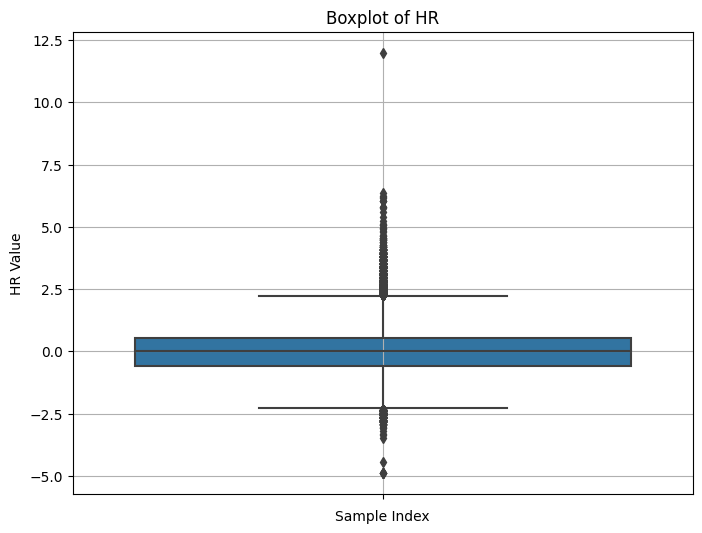

In [40]:
# Plots for HR attribute
plot_boxplot(train_loader, 1)

Here we plot the first attribute. You can investigate other attributes by changing the index in the `plot_boxplot` function.

#### Components of the Boxplot
- **Central Box**: Represents the interquartile range (IQR), containing the middle 50% of the data, with the bottom (Q1) and top (Q3) of the box indicating the first and third quartiles.
- **Median Line**: The line within the box shows the median of the data, providing a central value.
- **Whiskers**: These extend from the box to cover 1.5 times the IQR, defining the "normal" range of data, beyond which any points are considered outliers.
- **Outliers**: Points plotted beyond the whiskers are outliers, indicating unusual data points that are significantly higher or lower than the rest.

#### Interpretation in Time Series Context
- **Variability**: The spread of the box and the length of the whiskers illustrate the variability in HR values, which could suggest frequent fluctuations.
- **Central Tendency**: The median provides insight into the typical HR value around which data points tend to concentrate.
- **Outliers and Spikes**: Outliers may signal unusual events or errors in data collection, which are crucial in time series analysis to understand transient or abnormal behaviors.

## CSDI Algorithm

CSDI utilizes a conditional diffusion model trained specifically for imputation tasks. 
The imputation process with CSDI involves starting from random noise and gradually converting it into plausible time series data through the reverse process, conditioned on the observed values.


<p align="center">
<img src="figures/fig1.png" width="900"/>
</p>

<!-- ![Figure 1: Procedure of Time Series Imputation with CSDI](figures/fig1.png) -->

*Figure 1 illustrates the imputation procedure. The reverse process gradually removes noise from the noisy input, conditioned on observed values.*


Unlike traditional score-based models, which often approximate the conditional distribution, CSDI explicitly models the conditional distribution of missing values given observed data. Also the architecture of CSDI employs an attention mechanism to capture temporal and feature dependencies within the time series. These allow CSDI to better capture correlations and dependencies within the time series, leading to more accurate imputations. In general CSDI has three main components:

1. **Forward Process**:
   - The forward process gradually adds noise to the observed time series data, transforming it into a distribution of latent variables. This is achieved through a series of Markov transitions.
   - Over several steps, this process creates increasingly noisy versions of the original data.

2. **Reverse Process**:
   - The reverse process aims to denoise the noisy latent variables back into a plausible time series conditioned on the observed data.
   - This process is governed by a parameterized function that gradually removes noise, conditioned on the observed values.

3. **Self-Supervised Training**:
   - CSDI is trained using a self-supervised approach inspired by masked language modeling. In practice, ground-truth missing values are unknown, so the model is trained by masking parts of the observed data and treating them as targets for imputation.
   - This loss encourages the model to accurately predict the noise added to the data, effectively learning to impute missing values.


<p align="center">
<img src="figures/fig2.png" width="700"/>
</p>

<!-- ![Figure 2: Self-Supervised Training Procedure of CSDI](figures/fig2.png) -->

*Figure 2 depicts the self-supervised training procedure. The observed values (green) are split into imputation targets (red) and conditional observations (blue).*

<!-- #### Attention Mechanism

To capture temporal and feature dependencies within the multivariate time series, CSDI employs a two-dimensional attention mechanism in each residual layer. This involves a temporal Transformer layer and a feature Transformer layer, allowing the model to learn dependencies across both time and features.

<p align="center">
<img src="figures/fig3.png" width="1000"/>
</p>

<!-- ![Figure 3: Architecture of 2D Attention Mechanism](figures/fig3.png) -->

<!-- *Figure 3 shows the architecture of the 2D attention mechanism. The temporal Transformer layer learns temporal dependencies, while the feature Transformer layer captures feature dependencies.*

#### Applications and Performance --> 

CSDI has demonstrated superior performance in various imputation tasks, including:
- **Probabilistic Imputation**: Achieving significant improvements in continuous ranked probability score (CRPS) over existing methods.
- **Deterministic Imputation**: Reducing mean absolute error (MAE) compared to state-of-the-art deterministic imputation methods.
- **Time Series Interpolation and Forecasting**: Providing competitive results in these related tasks, showcasing its flexibility and robustness.


## Experiment Setup and Execution

This segment highlights the setup and execution of utilizing CSDI for time series imputation of physiological data. 

### Model Initialization
The model, `CSDI_Physio`, is initialized based on predefined configurations. This specialized model is designed to handle physiological time series data, inheriting robust functionalities from its base class to effectively manage the specific requirements of time series imputation tasks.

In [41]:
"""
class CSDI_Physio
   - A subclass of CSDI_base tailored specifically for handling physiological data from the PhysioNet dataset.
   - `config`: Configuration settings for the model.
   - `device`: Computation device (CPU or GPU).
   - `target_dim`: Number of features in the dataset, defaults to 35 for typical PhysioNet datasets.

def __init__
   - Initializes the CSDI_Physio class with the specified configuration, device, and target dimensions.
"""


class CSDI_Physio(CSDI_base):
    def __init__(self, config, device, target_dim=35):
        super(CSDI_Physio, self).__init__(target_dim, config, device)

    """
    def process_data
       - Processes input batch data for model training or evaluation.
       - `batch`: Dictionary containing 'observed_data', 'observed_mask', 'timepoints', and 'gt_mask'.
       - Transfers data to the specified device and converts it to float type for neural network processing.
       - Reorders data dimensions for compatibility with the model's expected input format.
       - Sets up `cut_length` as a tensor of zeros, indicating no specific cuts are applied to the data length.
       - Returns processed data components including data, masks, and time points for subsequent use in training or evaluation.
    """

    def process_data(self, batch):
        observed_data = batch["observed_data"].to(self.device).float()
        observed_mask = batch["observed_mask"].to(self.device).float()
        observed_tp = batch["timepoints"].to(self.device).float()
        gt_mask = batch["gt_mask"].to(self.device).float()

        observed_data = observed_data.permute(0, 2, 1)
        observed_mask = observed_mask.permute(0, 2, 1)
        gt_mask = gt_mask.permute(0, 2, 1)

        cut_length = torch.zeros(len(observed_data)).long().to(self.device)
        for_pattern_mask = observed_mask

        return (
            observed_data,
            observed_mask,
            observed_tp,
            gt_mask,
            for_pattern_mask,
            cut_length,
        )
    
# Set up model
model = CSDI_Physio(config, device).to(device)

## Model Training

### Output Folder Setup
Before training the model, an output directory is created to store training artifacts such as model checkpoints, logs, and output files. The directory name includes a timestamp to ensure uniqueness and to help track experiments based on the date and time they were performed.

- **Directory Naming**: The folder is named using the current date and time, which helps in organizing and retrieving model training sessions based on when they were conducted.
- **Creation**: The directory is created on the file system, ensuring it exists before any training outputs are written to it. This prevents errors related to file writing during model training.


In [42]:
# Set up output folder
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
foldername = f"./save/physio_{current_time}/"
os.makedirs(foldername, exist_ok=True)

### Model Training Process
The model is trained using the specified configurations, data loaders, and the path to the output directory. The training function is designed to handle both the training and validation phases within each epoch, allowing for a comprehensive assessment of model performance over time.

- **Training Function**: Takes the model, training configurations, and data loaders as inputs. Additionally, it accepts the path to the output folder where the training results are stored.
- **Validation Data**: Optionally, a validation loader can be passed to periodically evaluate model performance on a separate validation set during the training process.

### Loss Function
The loss function employed in the CSDI model is designed to optimize the model's ability to denoise data:
- **Denoising Loss**: During training, the model calculates the loss as the squared difference between the actual noise added to the data in the forward process and the noise predicted by the model during the reverse diffusion process. This loss function is key to training the model to accurately reverse the noise addition, effectively reconstructing the original data from its noisy version.

### Execution
Upon execution, the training process iteratively updates the model weights based on the loss computed from the training data. It also evaluates the model on the validation set, if provided, to monitor its performance on unseen data. Results and model states are saved in the designated output directory, facilitating post-training evaluations and model deployment.

<!-- ### Metrics
1. **Mean Absolute Error (MAE)**: This metric measures the average magnitude of errors in a set of predictions, without considering their direction. It's a linear score that averages the absolute differences between predicted and actual values, providing a straightforward interpretation of prediction accuracy.
2. **Continuous Ranked Probability Score (CRPS)**: CRPS is used to assess the accuracy of probabilistic predictions. It measures the difference between the predicted cumulative distribution function and the empirical distribution function of the observed data. This score is particularly useful for evaluating the performance of models that generate probabilistic or distributional forecasts. -->


In [ ]:
# Train the model
train(
    model,
    config["train"],
    train_loader,
    valid_loader=valid_loader,
    foldername=foldername,
)

## Loading a Pretrained Model

### Function for Loading Model State
To enhance or expedite the training process, or for evaluation purposes, you may start with a model that has already been trained. The function `load_pretrained_model` facilitates the loading of these pretrained weights into an existing model architecture.

- **Parameters**:
  - `model`: The model instance into which the pretrained weights will be loaded.
  - `modelfolder`: The subdirectory under `./save/` where the pretrained model is stored, defaulting to `pretrained`.
  - `device`: The computing device (CPU or GPU) where the model will be loaded. This ensures that the model is compatible with the hardware used for subsequent operations.

### Execution
The function constructs the full path to the pretrained model's state dictionary file (`model.pth`) using the specified `modelfolder`. It then loads this state dictionary into the model, ensuring that all model parameters are updated accordingly.

- **Model Compatibility**:
  - It is crucial that the model architecture into which the weights are being loaded matches the architecture of the model when it was saved. Incompatibility in architectures will lead to errors during the loading process.

<!-- ### Usage
To utilize a pretrained model, simply pass your initialized but untrained model to the `load_pretrained_model` function. This setup allows you to leverage previously learned patterns, potentially reducing training time and improving model robustness from the outset. -->

In [44]:

def load_pretrained_model(model_path, model, device=device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

# Path to the pre-trained model
model_path = "/projects/diffusion_bootcamp/models/time-seris/csdi/save/pretrained/model.pth"
# Load pre-trained model
model = load_pretrained_model(model_path, model)

In [45]:
# Set evaluation parameters
nsample = 100  # number of samples for evaluation
scaler = 1  # scaler for the data
mean_scaler = 0  # mean scaler for the data

## Model Evaluation

### Evaluation Parameters Configuration
Prior to evaluating the models, several key parameters are established:
- **`nsample`**: Specifies the number of samples to generate during model evaluation, set to 100 for comprehensive testing.
- **`scaler`** and **`mean_scaler`**: Define scaling factors for the data. These parameters adjust the data normalization during the evaluation to match the conditions used during model training.
- `test_missing_ratio`: Ratio of missing values in the test set.(Add some text to explain the parameter). Set to 0.1 to simulate a 10% missing data scenario during evaluation. This helps in assessing the model's robustness and performance under conditions of incomplete data.

### Data Loader Configuration
- The test data loader is updated to include the new missing ratio, ensuring that the evaluation tests the model's ability to handle and impute missing data effectively.

### Model Evaluation
- **Current Model Evaluation**: The initially trained model is evaluated using the updated `test_loader`. This step is crucial for understanding the baseline performance of the model on the test set.
- **Pre-trained Model Evaluation**: Additionally, a pre-trained model is evaluated under the same conditions. This is particularly useful for comparing the effectiveness of pre-training and fine-tuning strategies on model performance.


### Metrics
1. **Mean Absolute Error (MAE)**: This metric measures the average magnitude of errors in a set of predictions, without considering their direction. It's a linear score that averages the absolute differences between predicted and actual values, providing a straightforward interpretation of prediction accuracy.
2. **Continuous Ranked Probability Score (CRPS)**: CRPS is used to assess the accuracy of probabilistic predictions. It measures the difference between the predicted cumulative distribution function and the empirical distribution function of the observed data. This score is particularly useful for evaluating the performance of models that generate probabilistic or distributional forecasts.


### Execution
Both the current and pre-trained models are evaluated with the specified number of samples and scaling parameters. The results are stored in a designated folder, facilitating subsequent analysis and comparison:

In [46]:
missing_ratio = 0.1  # test missing ratio

# Update test_loader with new missing ratio
_, _, test_loader = get_dataloader(
    seed=1,
    nfold=0,
    batch_size=config["train"]["batch_size"],
    missing_ratio=missing_ratio,
)

In [ ]:
# Evaluate the current model with updated test_loader
evaluate(
    model,
    test_loader,
    nsample=nsample,
    scaler=scaler,
    mean_scaler=mean_scaler,
    foldername=foldername,
)

# Results Visualisation 

In [ ]:
def get_quantile(samples, q, dim=1):
    """
    Compute the q-th quantile of the data along the specified dimension.

    Args:
        samples (torch.Tensor): The data tensor from which to compute the quantile.
        q (float): The quantile to compute. This value should be between 0 and 1,
                   where 0 represents the minimum value and 1 represents the maximum value.
        dim (int, optional): The dimension along which to compute the quantile. 
                             Default is 1, which typically represents the time or feature dimension
                             in a multidimensional tensor.

    Returns:
        numpy.ndarray: The computed quantile values converted to a NumPy array.
    """
    # Compute the quantile using PyTorch's quantile function
    quantile_result = torch.quantile(samples, q, dim=dim)

    # Convert the result from a PyTorch tensor to a NumPy array and return
    # This conversion is typically necessary for compatibility with non-PyTorch processing,
    # or for easier data manipulation and plotting with libraries that use NumPy.
    return quantile_result.cpu().numpy()


In [ ]:
#datafolder = "pretrained"  # set the folder name
nsample = 100  # number of generated sample

#path = "./save/" + datafolder + "/generated_outputs_nsample" + str(nsample) + ".pk"
path = "./save/physio_20240722_031440/generated_outputs_nsample100.pk"

# Open the file containing the generated samples and related data
with open(path, "rb") as f:
    # Unpack all the necessary components from the pickle file
    (
        samples,          # Array of generated samples
        all_target,       # Array of target values for comparison with generated samples
        all_evalpoint,    # Evaluation points used during generation
        all_observed,     # Observed data points used to generate samples
        all_observed_time,# Time points corresponding to observed data
        scaler,           # Scaler object used to normalize/denormalize the data
        mean_scaler,      # Mean value used for scaling the data
    ) = pickle.load(f)

# Convert PyTorch tensors to NumPy arrays for easier manipulation if running on GPU or PyTorch-specific tensors
all_target_np = all_target.cpu().numpy()         # Target data as NumPy array
all_evalpoint_np = all_evalpoint.cpu().numpy()   # Evaluation points as NumPy array
all_observed_np = all_observed.cpu().numpy()     # Observed data as NumPy array

# Calculate the 'given' data by subtracting evaluation points from observed data
all_given_np = all_observed_np - all_evalpoint_np

# Extract the dimensions from the samples array
K = samples.shape[-1]  # Feature dimension: Represents the number of features in the sample data
L = samples.shape[-2]  # Time dimension: Represents the number of time steps in the sample data

In [ ]:
# List of quantiles to be computed
qlist = [0.05, 0.25, 0.5, 0.75, 0.95]

# Initialize an empty list to store the quantile-based imputed values
quantiles_imp = []

# Loop over each quantile in the list
for q in qlist:
    # Calculate the quantile for each sample
    # The `get_quantile` function computes the q-th quantile along a specified dimension of the samples
    # 'dim=1' indicates that the quantile is computed across each time series or feature individually
    quantile_values = get_quantile(samples, q, dim=1)

    # Compute the imputed values:
    # This step involves a weighted sum where:
    # 1. `(1 - all_given_np)` is a mask that indicates missing values (1 for missing and 0 for observed)
    # 2. `quantile_values * (1 - all_given_np)` applies the quantile values only to missing data points
    # 3. `all_target_np * all_given_np` keeps the original target values where data is not missing
    # Essentially, this replaces missing values in `all_target_np` with the quantile estimates
    imputed_data = quantile_values * (1 - all_given_np) + all_target_np * all_given_np
    
    # Append the result to the list of quantile imputations
    quantiles_imp.append(imputed_data)


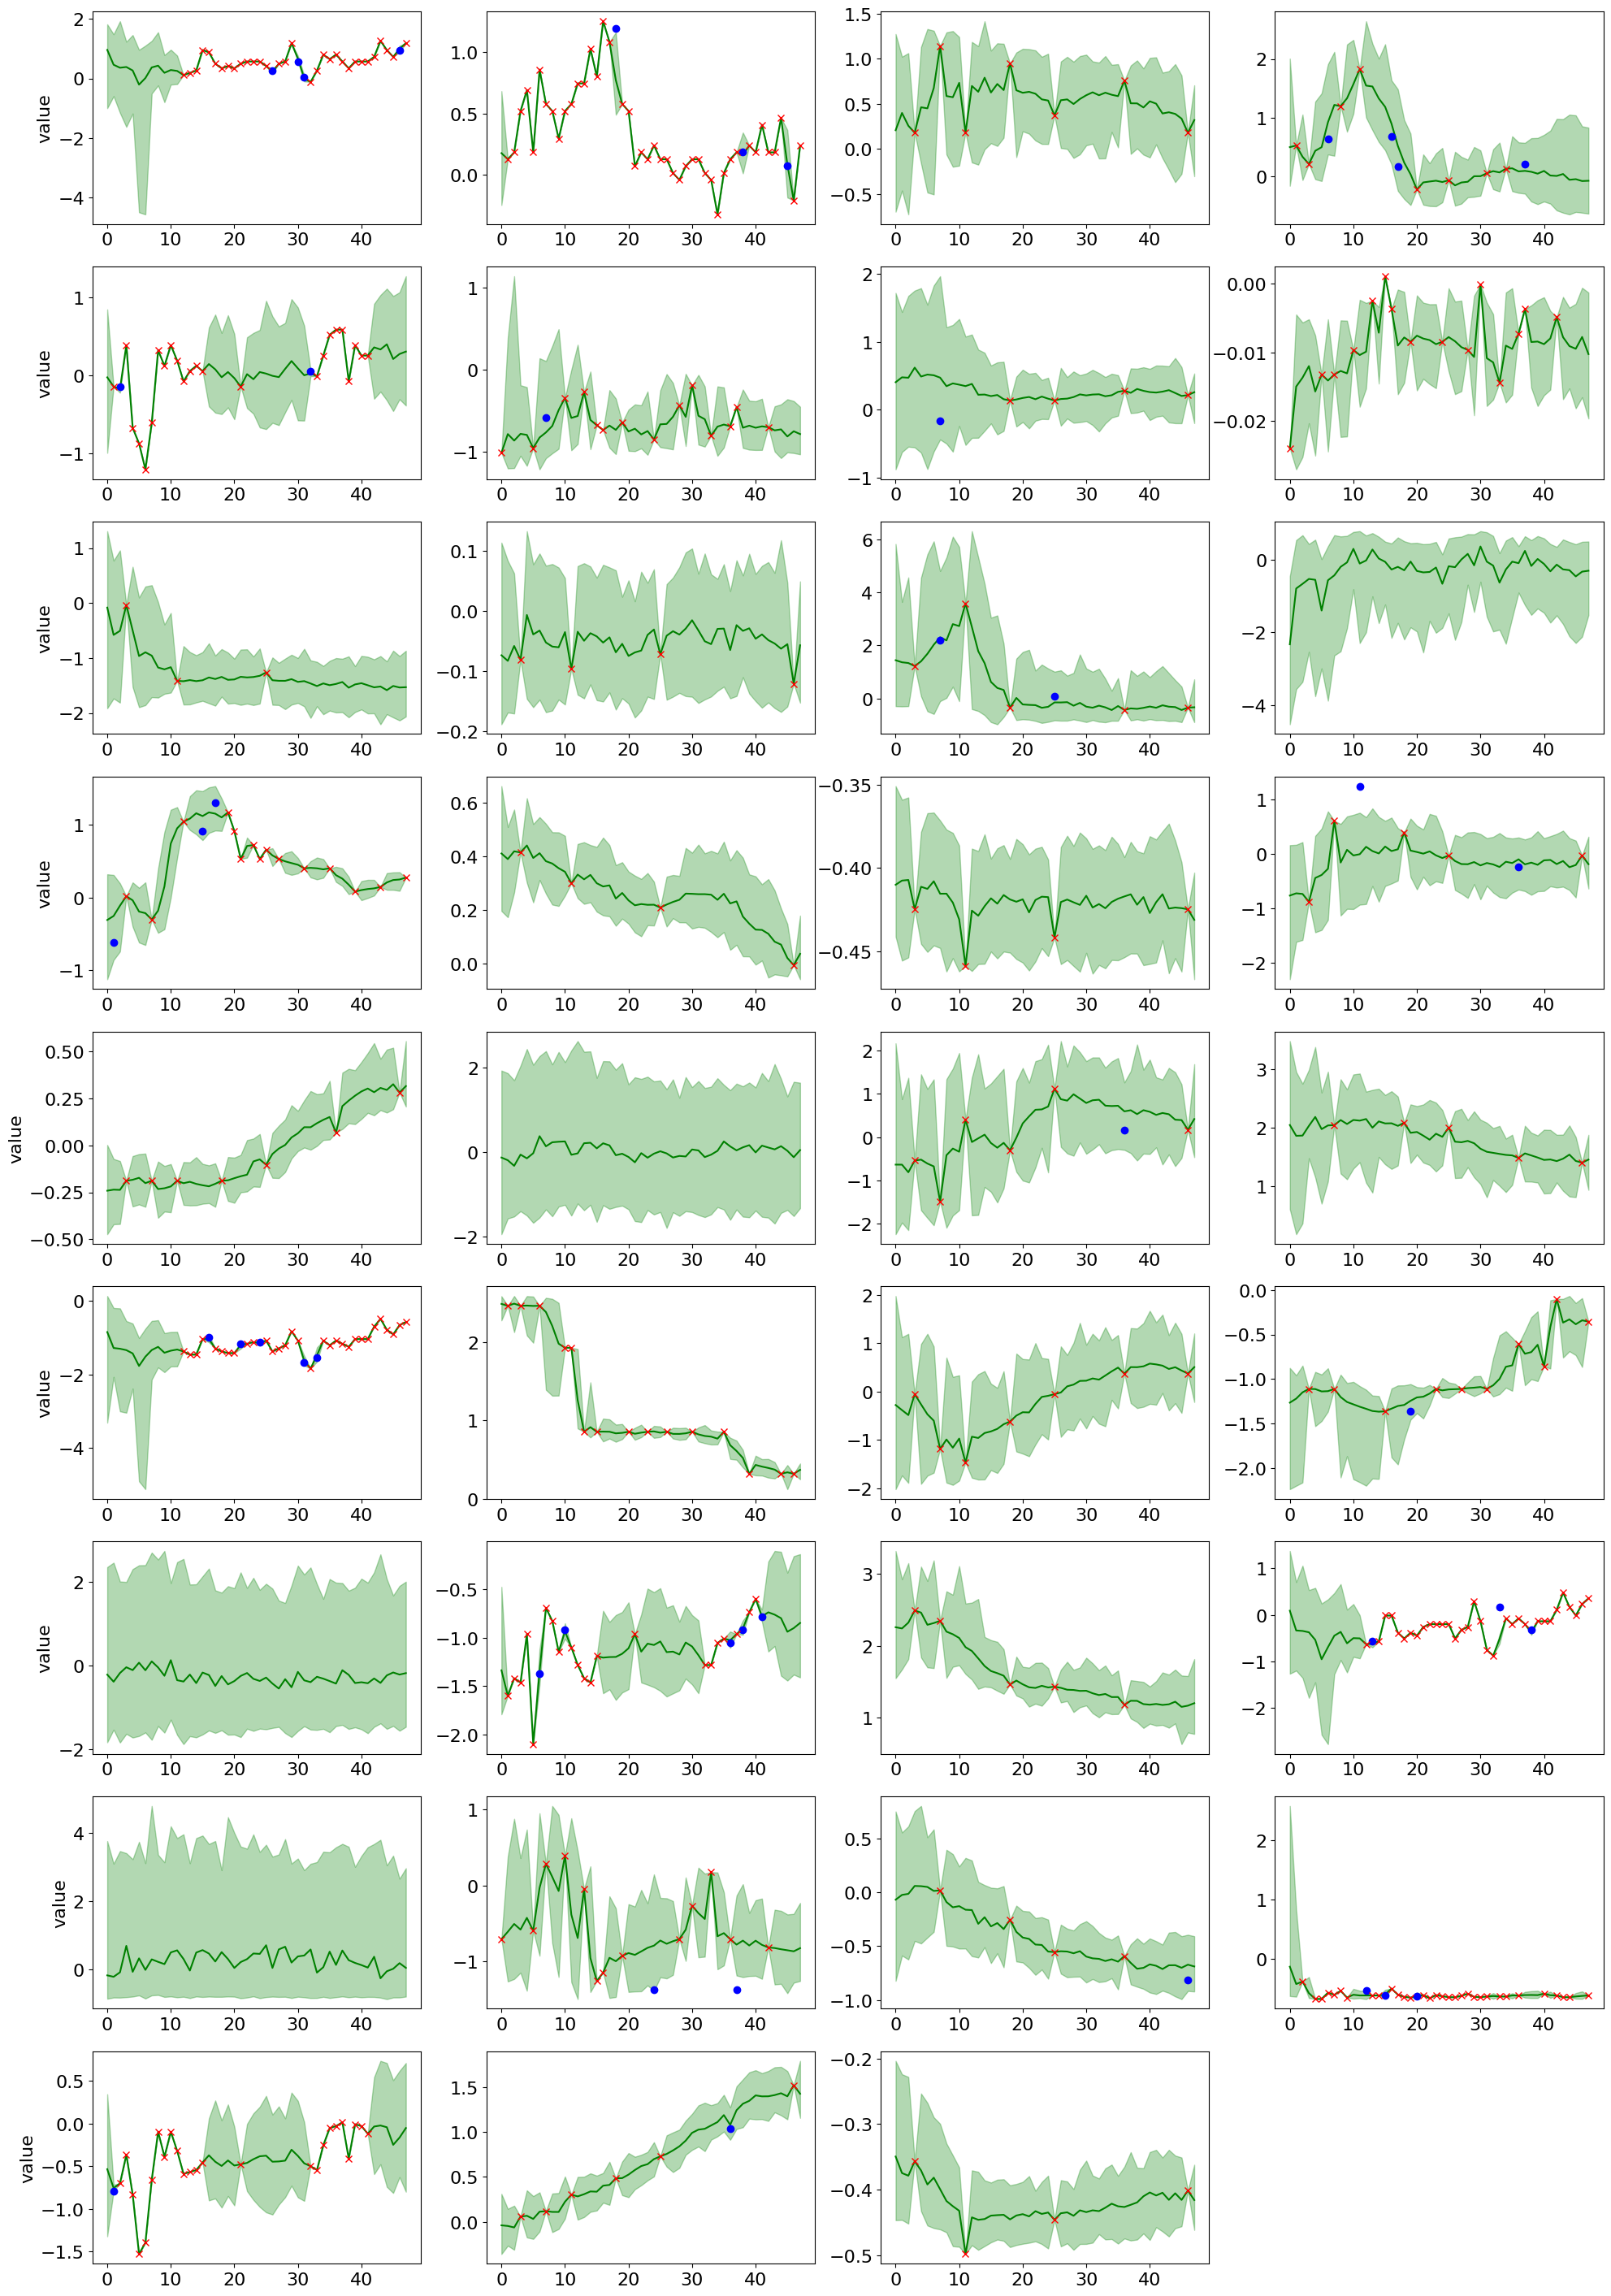

In [ ]:
# Set the index of the data sample to visualize
dataind = 3  # Change this to visualize a different time-series sample

# Configure plot aesthetics for better readability
plt.rcParams["font.size"] = 16
# Create a grid of subplots with 9 rows and 4 columns
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(24.0, 36.0))
# Remove the last subplot axis as it is not needed (36 slots, but only 35 attributes)
fig.delaxes(axes[-1][-1])

# Loop through each feature dimension K
for k in range(K):
    # Prepare a DataFrame for the first type of points (evaluation points)
    df = pd.DataFrame({
        "x": np.arange(0, L),  # Time steps
        "val": all_target_np[dataind, :, k],  # Target values at the current data index and feature
        "y": all_evalpoint_np[dataind, :, k],  # Evaluation points
    })
    # Filter out rows where evaluation points are zero (not evaluated)
    df = df[df.y != 0]

    # Prepare a second DataFrame for the second type of points (given points)
    df2 = pd.DataFrame({
        "x": np.arange(0, L),  # Time steps
        "val": all_target_np[dataind, :, k],  # Target values
        "y": all_given_np[dataind, :, k],  # Given points
    })
    # Filter out rows where given points are zero (not given)
    df2 = df2[df2.y != 0]

    # Determine the row and column index for the current subplot based on k
    row = k // 4
    col = k % 4

    # Plot the median of imputed values
    axes[row][col].plot(
        range(0, L),
        quantiles_imp[2][dataind, :, k],
        color="g",
        linestyle="solid",
        label="CSDI"  # Assuming CSDI is some type of imputed data label
    )

    # Fill between the lower and upper quantiles to show uncertainty or range
    axes[row][col].fill_between(
        range(0, L),
        quantiles_imp[0][dataind, :, k],
        quantiles_imp[4][dataind, :, k],
        color="g",
        alpha=0.3
    )

    # Plot evaluated points
    axes[row][col].plot(df.x, df.val, color="b", marker="o", linestyle="None")
    # Plot given points
    axes[row][col].plot(df2.x, df2.val, color="r", marker="x", linestyle="None")

    # Set y-label for the first column of subplots
    if col == 0:
        plt.setp(axes[row, 0], ylabel="value")
    # Set x-label for the last row of subplots
    if row == -1:
        plt.setp(axes[-1, col], xlabel="time")

### Overview of the Multi-Subplot Time Series Visualization

The figure comprises multiple subplots, each representing a distinct attribute measured over time. Each subplot includes several visual elements that detail aspects of the time series data.
In the dataset, each data point is a pair (x, y) where x is the time step and y is the corresponding value. The data points are not evenly spaced; we have y values only for specific x values. The red crosses represent observed data points, while the blue crosses indicate imputed values. The model provides a prediction for every possible x value, resulting in a continuous green line that represents these predictions across the entire range of x.

### Components of Each Subplot:

1. **Green Shaded Area**: Represents the range between the 5th and 95th percentiles of the data, indicating the variability and spread of the data over time.
2. **Solid Green Line**: This line is the median (50th percentile) of the data, providing a measure of central tendency across the time series.
3. **Blue Markers**: These markers denote actual observed data points, indicating where measurements were taken.
4. **Red Markers**: Represents evaluation points or imputed values that are used to fill in gaps or replace erroneous data points in the time series.

### Interpretation:

- **Data Distribution and Central Trend**: Each subplot displays the distribution and central trend of a different variable. The median line gives a clear indication of the central behavior of the dataset, while the shaded area shows the variability.
- **Observations vs. Imputations**: The presence of blue and red markers allows for an assessment of data quality. Subplots with significant overlap between blue and red markers indicate areas where observed data was sufficient or required minimal correction. In contrast, subplots with predominantly red markers suggest periods or attributes with significant missing data or anomalies that were addressed through imputation.


### References
- Tashiro, Yusuke, et al. "CSDI: Conditional Score-based Diffusion Models for Probabilistic Time Series Imputation." *Advances in Neural Information Processing Systems*. 2021. [GitHub Repository](https://github.com/ermongroup/CSDI)
